# STEP 4: Count the number of observations in each ecosystem, during

each month of 2023

Much of the data in GBIF is **crowd-sourced**. As a result, we need not
just the number of observations in each ecosystem each month – we need
to **normalize** by some measure of **sampling effort**. After all, we
wouldn’t expect the same number of observations in the Arctic as we
would in a National Park, even if there were the same number of Veeries.
In this case, we’re normalizing using the average number of observations
for each ecosystem and each month. This should help control for the
number of active observers in each location and time of year.

### Set up your analysis

First things first – let’s load your stored variables.

In [1]:
%store -r

### Identify the ecoregion for each observation

You can combine the ecoregions and the observations **spatially** using
a method called `.sjoin()`, which stands for spatial join.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out the <a
href="https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins"><code>geopandas</code>
documentation on spatial joins</a> to help you figure this one out. You
can also ask your favorite LLM (Large-Language Model, like ChatGPT)</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Perform a spatial join</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Identify the correct values for the <code>how=</code> and
<code>predicate=</code> parameters of the spatial join.</li>
<li>Select only the columns you will need for your plot.</li>
<li>Run the code.</li>
</ol></div></div>

In [13]:
gbif_ecoregion_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
    # reproject smaller dataset
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='contains')
    # Select the required columns
    [['gbifID','OBJECTID','month', 'ECO_NAME']]
    .rename(columns={'OBJECTID': 'ecoregion',
                     'gbifID': 'observation_id'})
)
#'index_right'
# 'index_right':'observation_id'
gbif_ecoregion_gdf

,observation_id,ecoregion,month,ECO_NAME
12,4743927038,13.0,5,Alberta-British Columbia foothills forests
12,4621947377,13.0,5,Alberta-British Columbia foothills forests
12,4761090115,13.0,6,Alberta-British Columbia foothills forests
12,4765238615,13.0,7,Alberta-British Columbia foothills forests
12,4630693711,13.0,6,Alberta-British Columbia foothills forests
...,...,...,...,...
839,4633848077,845.0,10,North Atlantic moist mixed forests
839,4749131402,845.0,9,North Atlantic moist mixed forests
839,4763942306,845.0,9,North Atlantic moist mixed forests
839,4746476478,845.0,9,North Atlantic moist mixed forests


### Count the observations in each ecoregion each month

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Group observations by ecoregion</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>columns_to_group_by</code> with a list of columns.
Keep in mind that you will end up with one row for each group – you want
to count the observations in each ecoregion by month.</li>
<li>Select only month/ecosystem combinations that have more than one
occurrence recorded, since a single occurrence could be an error.</li>
<li>Use the <code>.groupby()</code> and <code>.mean()</code> methods to
compute the mean occurrences by ecoregion and by month.</li>
<li>Run the code – it will normalize the number of occurrences by month
and ecoregion.</li>
</ol></div></div>

In [14]:
occurrence_df = (
    gbif_ecoregion_gdf
    # For each ecoregion, for each month...
    #(could group by "ecoregion" instead for number version- what Elsa did)
    .groupby(['ECO_NAME','month'])
    # ...count the number of occurrences
    .agg(occurrences=('observation_id','count'))
)
occurrence_df

occurrences
ECO_NAME                                   month             
Alberta-British Columbia foothills forests 5                2
                                           6                2
                                           7                2
Allegheny Highlands forests                4                2
                                           5             2980
...                                                       ...
Yucatán moist forests                      4                6
                                           5                6
                                           7                1
                                           9                1
                                           10               6

[350 rows x 1 columns]

In [17]:
# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>1]

occurrence_df

# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby('ECO_NAME')
    .mean()
)
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)

mean_occurrences_by_ecoregion

,occurrences
ECO_NAME,
Alberta-British Columbia foothills forests,2.000000
Allegheny Highlands forests,1425.333333
Amazon-Orinoco-Southern Caribbean mangroves,3.000000
Appalachian Piedmont forests,355.400000
Appalachian mixed mesophytic forests,243.142857
...,...
Western Gulf coastal grasslands,658.400000
Western shortgrass prairie,77.666667
Wyoming Basin shrub steppe,11.666667


### Normalize the observations

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Normalize</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Divide occurrences by the mean occurrences by month AND the mean
occurrences by ecoregion</li>
</ol></div></div>

In [19]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df
    / mean_occurrences_by_ecoregion
    / mean_occurrences_by_month
)
occurrence_df

occurrences  \
ECO_NAME                                   month                
Alberta-British Columbia foothills forests 5                2   
                                           6                2   
                                           7                2   
Allegheny Highlands forests                4                2   
                                           5             2980   
...                                                       ...   
Wyoming Basin shrub steppe                 8                5   
Yucatán dry forests                        4                2   
Yucatán moist forests                      4                6   
                                           5                6   
                                           10               6   

                                                  norm_occurrences  
ECO_NAME                                   month                    
Alberta-British Columbia foothills forests 5              0.000828  
                                           6              0.000960  
                                           7              0.001746  
Allegheny Highlands forests                4              0.000010  
                                           5              0.001732  
...                                                            ...  
Wyoming Basin shrub steppe                 8              0.002598  
Yucatán dry forests                        4              0.007119  
Yucatán moist forests                      4              0.007119  
                                           5              0.000828  
                                           10             0.030465  

[308 rows x 2 columns]

<Axes: xlabel='month', ylabel='occurrences'>

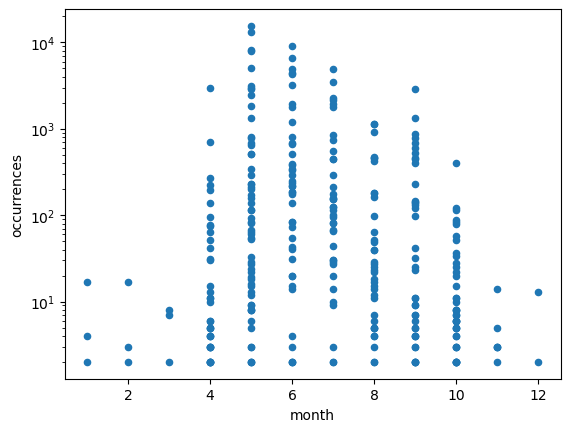

In [24]:
# rough plot
#occurrence_df.norm_occurrences.plot.hist()
occurrence_df.reset_index().plot.scatter(
x = 'month', y = 'occurrences',
logy = True
)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure to store the new version of your <code>DataFrame</code> for
other notebooks!</p>
<div id="2e01613b" class="cell" data-execution_count="9">
<div class="sourceCode" id="cb1"><pre
class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a><span class="op">%</span>store occurrence_df</span></code></pre></div>
</div></div></div>

In [25]:
%store occurrence_df

Stored 'occurrence_df' (DataFrame)


In [42]:
# practice conditionals

# Set x to 10
x = 10

# Compare x to 10
if x == 10:
    print("x is equal to 10.")    
else:
    print("x has a value of", x, "which is not equal to 10.")   


x is equal to 10.
